In [33]:
import itertools
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, MessagePassing

import networkx as nx
import matplotlib.pyplot as plt

In [34]:
def get_unique_number(data=None):
    # get unique number of every axis(column) of data
    # todo
    x_grid_size = 4
    y_grid_size = 3
    return [x_grid_size, y_grid_size]

In [35]:
unique_number = get_unique_number()
num_nodes = np.product(unique_number)
x_grid_size, y_grid_size = unique_number

In [36]:
# define node and edge features
node_features = torch.tensor(
    [[i, j] for j in range(y_grid_size) for i in range(x_grid_size)], dtype=torch.float
)

edges = []
for j in range(y_grid_size):
    for i in range(x_grid_size):
        node_id = j * x_grid_size + i
        # out: up, right
        if i < x_grid_size - 1:
            edges.append([node_id, j * x_grid_size + (i + 1)])
        if j < y_grid_size - 1:
            edges.append([node_id, (j + 1) * x_grid_size + i])
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
data = Data(x=node_features, edge_index=edge_index)

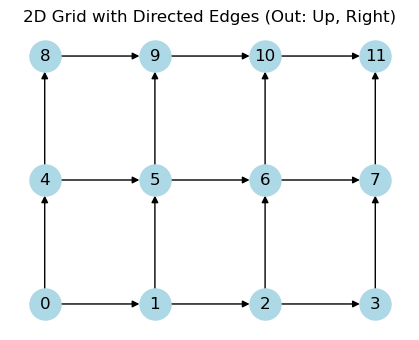

In [37]:
# visualize the graph
G = to_networkx(data, to_undirected=False)
pos = {i: (data.x[i, 0].item(), data.x[i, 1].item()) for i in range(data.x.shape[0])}
plt.figure(figsize=(4, 3))
nx.draw(
    G, pos, with_labels=True, node_color="lightblue", node_size=500, arrows=True, arrowstyle="-|>"
)
plt.title("2D Grid with Directed Edges (Out: Up, Right)")
plt.show()

In [38]:
# generate train and test set
num_labels = 5

labels = torch.full((num_nodes,), float("nan"))
selected_points = torch.randperm(num_nodes)[:num_labels]
labels[selected_points] = (selected_points + 1) / num_nodes  # CDF F(x)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[selected_points] = True
data.y = labels
data.train_mask = train_mask

In [39]:
# model 1
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)
        x = torch.max(x, dim=1)[0]  # torch.max(x, dim=1, keepdim=True)[0]
        return x

In [40]:
# model 2
class MaxAggConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MaxAggConv, self).__init__(aggr="max")  # Use 'max' as the aggregation method
        # Add a linear transformation (learnable weights)
        self.lin = nn.Linear(in_channels, out_channels)  #

    def forward(self, x, edge_index):
        # Apply the linear transformation before propagating
        x = self.lin(x)  #
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # Apply a function to the message (incoming node features)
        # return F.sigmoid(x_j)
        return x_j

    def update(self, aggr_out):
        # Return the aggregated values (max values from neighbors)
        return aggr_out


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = MaxAggConv(in_channels, hidden_channels)
        self.conv2 = MaxAggConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(2, 16, 1).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

In [42]:
# model output before training
out = model(data).squeeze(dim=-1).detach().cpu()
out[data.train_mask], data.y[data.train_mask]

(tensor([-0.2670, -0.1478, -0.4370, -0.1966, -0.4812]),
 tensor([0.3333, 0.5833, 0.6667, 0.9167, 1.0000]))

In [43]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data).squeeze(dim=-1)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [44]:
for epoch in range(2000):
    loss = train()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

Epoch 0, Loss: 1.1092514991760254
Epoch 200, Loss: 3.143080220979755e-06
Epoch 400, Loss: 6.574016424565343e-07
Epoch 600, Loss: 5.894223136237997e-07
Epoch 800, Loss: 4.933735340273415e-07
Epoch 1000, Loss: 4.2487712903493957e-07
Epoch 1200, Loss: 3.936102075385861e-07
Epoch 1400, Loss: 3.027624586593447e-07
Epoch 1600, Loss: 1.852964430781867e-07
Epoch 1800, Loss: 1.423069591055537e-07


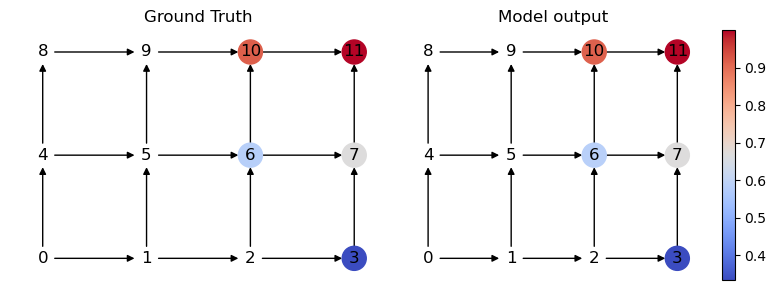

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Ground truth
G = to_networkx(data, to_undirected=False)
nx.draw(G, pos, with_labels=True, node_color=data.y.cpu(), cmap=plt.get_cmap("coolwarm"), ax=axs[0])
axs[0].set_title("Ground Truth")

# model output
model.eval()
out = model(data).squeeze()
masked_out = torch.full(out.shape, float("nan"))
masked_out[data.train_mask] = out[data.train_mask]

nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=masked_out.detach().cpu(),
    cmap=plt.get_cmap("coolwarm"),
    ax=axs[1],
)
axs[1].set_title("Model output")

plt.colorbar(axs[1].collections[0], ax=axs[1])
plt.tight_layout()
plt.show()

In [46]:
out[data.train_mask], data.y[data.train_mask]

(tensor([0.3337, 0.5837, 0.6670, 0.9164, 0.9997], grad_fn=<IndexBackward0>),
 tensor([0.3333, 0.5833, 0.6667, 0.9167, 1.0000]))

In [47]:
out

tensor([0.0000, 0.2044, 0.2701, 0.3337, 0.2044, 0.2701, 0.5837, 0.6670, 0.2701,
        0.5837, 0.9164, 0.9997], grad_fn=<SqueezeBackward0>)